# Libraries

In [ ]:
import os

import random

import numpy as np
import pandas as pd

import scipy as sp
from scipy import signal

import matplotlib.pyplot as plt

import librosa, librosa.display
import IPython.display as ipd

import sklearn
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

In [ ]:
!pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.1 MB/s eta 0:00:00


In [ ]:
!pip install noisereduce

In [ ]:
import noisereduce as nr

# Dataset

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !wget -c --no-check-certificate "https://drive.google.com/u/0/uc?id=1AFySnqxTCFhdeZZ02XpbUStgJyZoAirw&confirm=t" -O audios.zip

In [ ]:
# !wget --no-check-certificate "https://drive.google.com/u/0/uc?id=13fPmh97a4_UrmPkktJ-g8_-uEy2KhrCm&confirm=t" -O audios_completos.zip

Ultimamente no me descargaba la carpeta de los audios de esta forma, asi que los subi a mi cuenta de drive, no se que podria ser, ya intente solucionar pero no quise perder mucho tiempo.

In [ ]:
!cp drive/MyDrive/Audios_disparos_selva.zip /content/audios.zip

In [ ]:
!cp drive/MyDrive/lotes_procesar.zip /content/audios_completos.zip

In [ ]:
!unzip audios.zip

Streaming output truncated to the last 5000 lines.
  inflating: Audios_disparos_selva/val/fondo/5AD0E52D.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0EAF2.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0EEC0.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0F031.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0F069.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0F06B.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0F07C.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0F08C.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0F41A.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0F47E.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0F89D.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0FB05.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0FF9F.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD106B9.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD10E89.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD1

In [ ]:
!unzip audios_completos.zip

Archive:  audios_completos.zip
   creating: lotes_procesar/
  inflating: lotes_procesar/BO-01_OBBA-4_20191009_174300.mp3  
  inflating: lotes_procesar/BO-01_OBBA-4_20191009_182300.mp3  
  inflating: lotes_procesar/BO-01_OBBA-4_20191009_190300.mp3  
  inflating: lotes_procesar/BO-01_OBBA-4_20191009_194300.mp3  
  inflating: lotes_procesar/BO-01_OBBA-4_20191009_211300.mp3  
  inflating: lotes_procesar/BO-01_OBBA-4_20191009_221300 .mp3  
  inflating: lotes_procesar/BO-01_OBBA-4_20191010_001300 .mp3  
  inflating: lotes_procesar/BO-01_OBBA-4_20191010_050900 .mp3  
  inflating: lotes_procesar/BO-01_OBBA-4_20191010_054900 .mp3  
  inflating: lotes_procesar/BO-01_OBBA-4_20191010_062900 .mp3  
  inflating: lotes_procesar/BO-02_OBBA-5_20191009_174300 .mp3  
  inflating: lotes_procesar/BO-02_OBBA-5_20191009_182300 .mp3  
  inflating: lotes_procesar/BO-02_OBBA-5_20191009_190300 .mp3  
  inflating: lotes_procesar/BO-02_OBBA-5_20191009_194300 .mp3  
  inflating: lotes_procesar/BO-02_OBBA-5_20191009

In [ ]:
os.remove('/content/Audios_disparos_selva/train/fondo/603EFD8C.WAV')
os.remove('/content/Audios_disparos_selva/train/fondo/603EEE5A.WAV')

# Explore Dataset

## Auxiliaries functions

In [ ]:
SAMPLE_RATE = 16000
FRAME_LENGTH = 1024
HOP_LENGTH = FRAME_LENGTH//2
N_MELS = 40
N_MFCC = 13

In [ ]:
from audiomentations import Compose, BandPassFilter

def filters(signal, sr):
  augment = Compose([
      BandPassFilter(min_center_freq=100.0, max_center_freq=2048, p=1.0),
  ])

  return augment(signal, sr)

In [ ]:
def extract_envelope(signal):
  return np.array([max(signal[i:i+FRAME_LENGTH]) for i in range(0, len(signal), HOP_LENGTH)])

In [ ]:
def extract_fft(signal):
  signal_fft = sp.fft.fft(signal, FRAME_LENGTH)
  signal_mag = np.abs(signal_fft)

  return signal_fft, signal_mag

In [ ]:
def extract_spectrogram(signal):
  return np.abs(librosa.stft(signal,
                             n_fft=FRAME_LENGTH,
                             hop_length=HOP_LENGTH))

In [ ]:
def extract_mel_spectrogram(signal, sr):
  signal_mel_spectrogram = librosa.feature.melspectrogram(y=signal,
                                                          sr=sr,
                                                          n_fft=FRAME_LENGTH,
                                                          hop_length=HOP_LENGTH,
                                                          n_mels=N_MELS)

  signal_log_mel_spectrogram = librosa.power_to_db(signal_mel_spectrogram)

  return signal_log_mel_spectrogram

In [ ]:
def extract_mfccs(signal, sr):
  mfccs = librosa.feature.mfcc(y=signal,
                               n_fft=FRAME_LENGTH,
                               hop_length=HOP_LENGTH,
                               n_mfcc=N_MFCC,
                               sr=sr)

  # mfccs = mfccs / np.abs(mfccs.max())

  mfccs = normalize(mfccs)

  return mfccs[1:]

In [ ]:
def extract_spectral_contrast(signal, sr):
  spectrogram = extract_spectrogram(signal)
  contrast = librosa.feature.spectral_contrast(y=spectrogram,
                                               sr=sr,
                                               n_fft=FRAME_LENGTH,
                                               hop_length=HOP_LENGTH,
                                               n_bands=5)

  return np.squeeze(contrast)

In [ ]:
def extract_delta(signal, order):
  delta = librosa.feature.delta(signal, order=order)
  delta = delta / np.abs(delta.max())

  return delta

In [ ]:
def normalize(x, axis=0):
  return sklearn.preprocessing.minmax_scale(x, axis=axis)

def extract_spectral_centroid(signal, sr):
  return librosa.feature.spectral_centroid(y=signal,
                                             sr=sr,
                                             n_fft=FRAME_LENGTH,
                                             hop_length=HOP_LENGTH)[0]

In [ ]:
def plot_waveform(signal, sr, audio_type=None):

  signal = signal / signal.max()

  envelope = extract_envelope(signal)

  frames = range(0, envelope.size)
  t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)

  plt.figure(figsize=(8, 5))

  librosa.display.waveshow(signal, sr=sr, alpha=0.5)
  plt.plot(t, envelope, color="r")
  plt.ylim((-1.1, 1.1))
  plt.title(f"Envelope to {audio_type}")

In [ ]:
def plot_fft(signal, sr, audio_type=None):
  signal_fft, signal_mag = extract_fft(signal)

  frequency = np.linspace(0, sr, len(signal_fft))
  f_bins = FRAME_LENGTH//2 + 1

  plt.figure(figsize=(8, 4))
  plt.plot(frequency[:f_bins], signal_mag[:f_bins])

  plt.xlabel('Frequency [Hz]')
  plt.ylabel('Amplitude')
  plt.title(f'Frequency domain spectrum to {audio_type}')
  plt.show()

In [ ]:
def plot_spectrogram(signal, sr, y_axis='linear', audio_type=None):
  spectrogram = extract_spectrogram(signal)

  if y_axis == 'log':
    spectrogram = librosa.amplitude_to_db(spectrogram)

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(spectrogram,
                           sr=sr,
                           y_axis=y_axis,
                           x_axis='time')

  plt.title(f'Spectrogram to {audio_type}')
  plt.colorbar(format='%+2.f')
  plt.show()


In [ ]:
def plot_mel_spectrogram(signal, sr, audio_type=None):
  mel_spectrogram = extract_mel_spectrogram(signal, sr)

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(mel_spectrogram,
                           sr=sr,
                           y_axis='mel',
                           x_axis='time')

  plt.title(f'Mel spectrogram to {audio_type}')
  plt.colorbar(format='%+2.f')
  plt.show()

In [ ]:
def plot_mfcc(data, sr, audio_type=None):

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(data,
                           x_axis="time",
                           sr=sr)

  plt.title(f'Mel Frequency Cepstral Coeﬃcients to {audio_type}')
  plt.ylabel('Coefficients')
  plt.colorbar(format="%+2.f")
  plt.show()

In [ ]:
def plot_spectral_centroid(signal, sr, audio_type=None):

  spectral_centroids = extract_spectral_centroid(signal, sr)

  frames = range(len(spectral_centroids))
  t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_LENGTH)

  plt.figure(figsize=(8, 4))
  librosa.display.waveshow(y=signal, sr=sr, color='b')

  plt.plot(t, normalize(spectral_centroids), color='r')
  plt.title(f'Spectral centroids to {audio_type}')
  plt.show()

## Load audios names

In [ ]:
DATASET_PATH = './Audios_disparos_selva/train'
VAL_DATASET_PATH = './Audios_disparos_selva/val'

In [ ]:
def load_dataset_names(dataset_path: str) -> dict:
  DATASET = {
      'audio_name': [],
      'labels': []
  }

  for i, (dirpath, _, filenames) in enumerate(os.walk(dataset_path)):

    if dirpath != dataset_path:

      if dirpath.split('/')[-1] == 'fondo':

        for f in filenames:
          file_path = os.path.join(dirpath, f)
          DATASET['audio_name'].append(file_path)
          DATASET['labels'].append(0)
      else:
        for f in filenames:
          file_path = os.path.join(dirpath, f)
          DATASET['audio_name'].append(file_path)
          DATASET['labels'].append(1)

  return DATASET

In [ ]:
DATASET = pd.DataFrame(load_dataset_names(DATASET_PATH))
VAL_DATASET = pd.DataFrame(load_dataset_names(VAL_DATASET_PATH))

In [ ]:
DATASET

,audio_name,labels
0,./Audios_disparos_selva/train/disparos/5BCE4CE...,1
1,./Audios_disparos_selva/train/disparos/5CACBD0...,1
2,./Audios_disparos_selva/train/disparos/58FFBCD...,1
3,./Audios_disparos_selva/train/disparos/5BF006C...,1
4,./Audios_disparos_selva/train/disparos/58FFC19...,1
...,...,...
11223,./Audios_disparos_selva/train/fondo/5CACC197.WAV,0
11224,./Audios_disparos_selva/train/fondo/5CB7F8FF.WAV,0
11225,./Audios_disparos_selva/train/fondo/5C6DEDB4.WAV,0
11226,./Audios_disparos_selva/train/fondo/5C81C2A5.WAV,0


## Relationship between shot and background

In [ ]:
back_cant = DATASET['labels'][DATASET['labels'] == 0].count()
shot_cant = DATASET['labels'][DATASET['labels'] == 1].count()

print(f"Number of shots: {shot_cant} and background: {back_cant}")

Number of shots: 597 and background: 10631


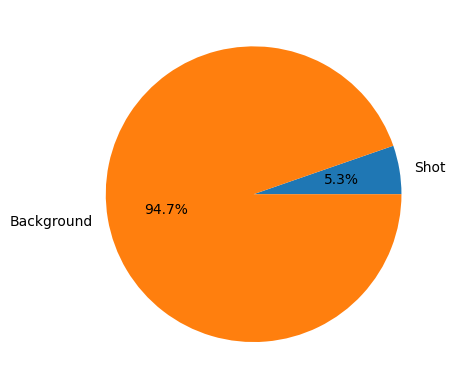

In [ ]:
labels = 'Shot', 'Background'
shot_percent = shot_cant / (shot_cant + back_cant)
back_percent = back_cant / (shot_cant + back_cant)

fig, ax = plt.subplots()
_, _, _ = ax.pie((shot_percent, back_percent), labels=labels, autopct='%1.1f%%')

## Choose random audio

In [ ]:
shot_name = VAL_DATASET['audio_name'][VAL_DATASET['labels'] == 1].sample().values[0]
back_name = VAL_DATASET['audio_name'][VAL_DATASET['labels'] == 0].sample().values[0]

shot_sound, shot_sr = librosa.load(shot_name, sr=SAMPLE_RATE)

shot_sound = filters(nr.reduce_noise(y=shot_sound,
                                     sr=SAMPLE_RATE,
                                     n_fft=FRAME_LENGTH,
                                     hop_length=HOP_LENGTH), shot_sr)

back_sound, back_sr = librosa.load(back_name, sr=SAMPLE_RATE)

back_sound = filters(nr.reduce_noise(y=back_sound,
                                     sr=SAMPLE_RATE,
                                     n_fft=FRAME_LENGTH,
                                     hop_length=HOP_LENGTH), back_sr)

Los audios de entrenamiento al parecer estan a 8KHz, y los que hay que procesar a 16kHz, y como utilice audios extras a otras frecuencias de muestreo defini 16kHz por defecto, el espectro en frecuencia no cambia mucho, que es lo que utilizo

Ademas, el espectro de un disparo esta entre 0 y 3kHz aproximadamente, un poco mas, un poco menos, por lo tanto, se filtra la señal de entrada de 100 a 2048Hz de momento.

## Basic information regarding audios

In [ ]:
shot_sound.shape

(64000,)

In [ ]:
# duration of 1 sample (shoot or background)
duration_sample = 1 / back_sr
print(f"Duration of 1 sample is: {duration_sample:.6f} seconds")

Duration of 1 sample is: 0.000063 seconds


In [ ]:
back_sr

16000

In [ ]:
# total number of samples in audio file
tot_samples = len(back_sound)
tot_samples

64000

In [ ]:
# duration of the audio signal in seconds
duration = duration_sample * len(back_sound)
print(f"Duration of signal is: {duration:.2f} seconds")

Duration of signal is: 4.00 seconds


## Listen audios

In [ ]:
ipd.Audio(shot_sound, rate=SAMPLE_RATE)

In [ ]:
ipd.Audio(back_sound, rate=SAMPLE_RATE)

## Visualize graphs

### Envelope

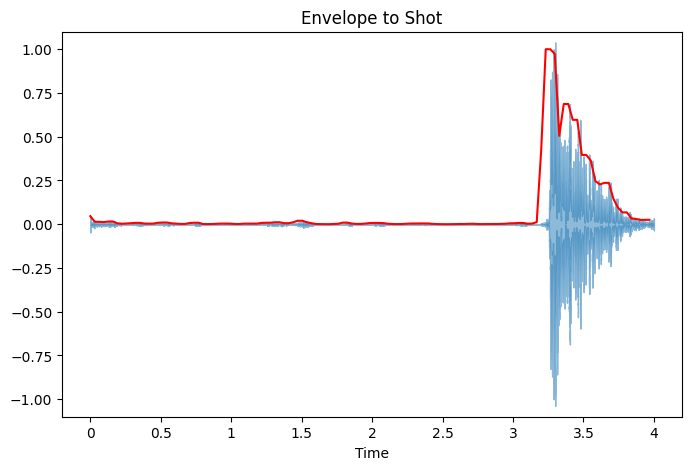

In [ ]:
# SHOT

plot_waveform(shot_sound, SAMPLE_RATE, 'Shot')

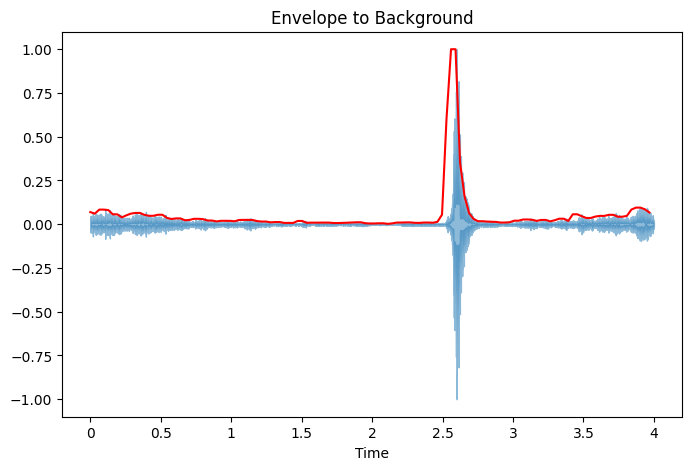

In [ ]:
# BACKGROUND

plot_waveform(back_sound, SAMPLE_RATE, 'Background')

### Frequency domain

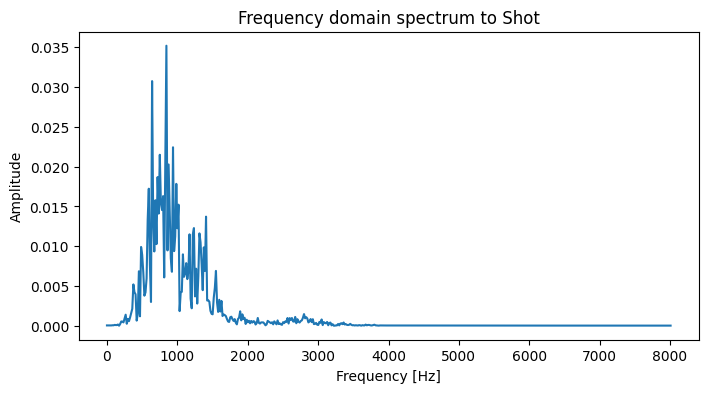

In [ ]:
# SHOT
plot_fft(shot_sound, SAMPLE_RATE, audio_type='Shot')

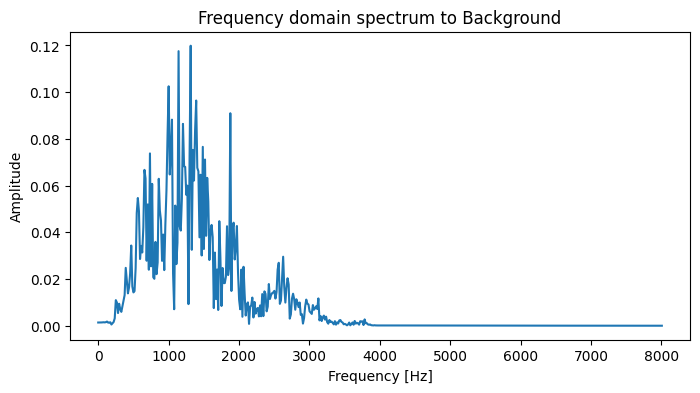

In [ ]:
# BACKGROUND
plot_fft(back_sound, SAMPLE_RATE, audio_type='Background')

### Spectrogram

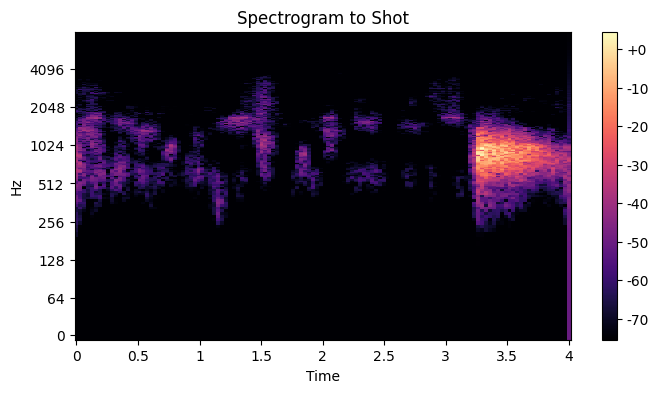

In [ ]:
# SHOT
plot_spectrogram(shot_sound, SAMPLE_RATE, y_axis='log', audio_type='Shot')

In [ ]:
spect = extract_spectrogram(shot_sound)
spect.shape

(513, 126)

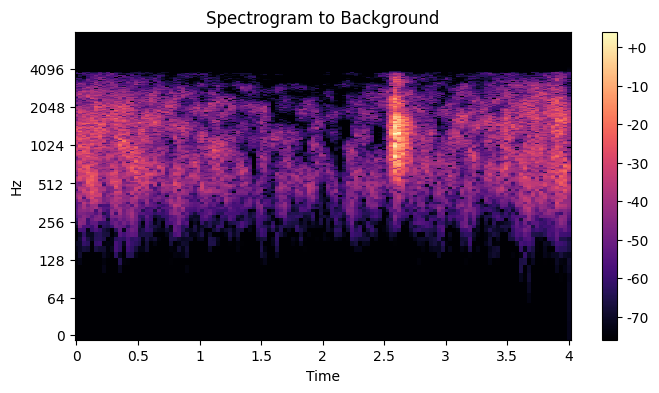

In [ ]:
# BACKGROUND
plot_spectrogram(back_sound, SAMPLE_RATE, y_axis='log', audio_type='Background')

### Mel spectrogram

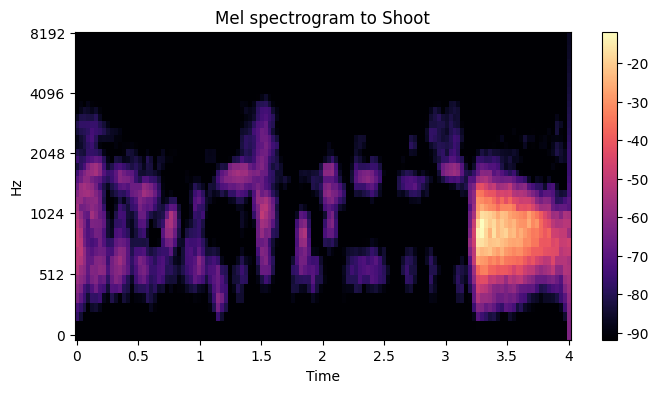

In [ ]:
# SHOT
plot_mel_spectrogram(shot_sound, SAMPLE_RATE, audio_type='Shoot')

Se puede ver como el espectro de un disparo tiene casi siempre la misma forma, lo que diferencia de un ruido de fondo o de otras cosas, lo que se puede llegar a confundir puede ser un golpe seco o un palo rompiendose, pero en el espectro se nota bastante la diferencia.

In [ ]:
mel_spect = extract_mel_spectrogram(shot_sound, shot_sr)
mel_spect.shape

(40, 126)

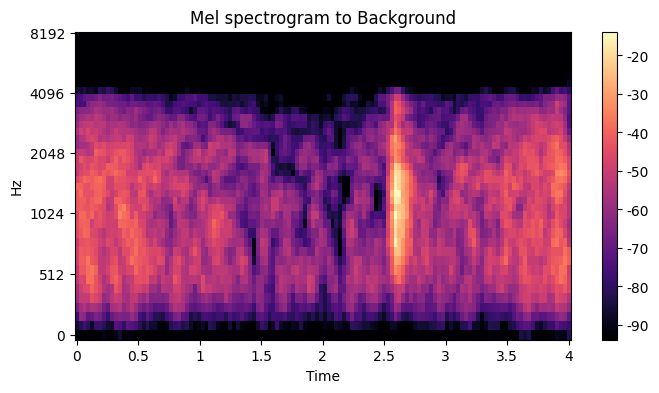

In [ ]:
# BACKGROUND
plot_mel_spectrogram(back_sound, SAMPLE_RATE, audio_type='Background')

### Mel-Frequency Cepstral Coefficients

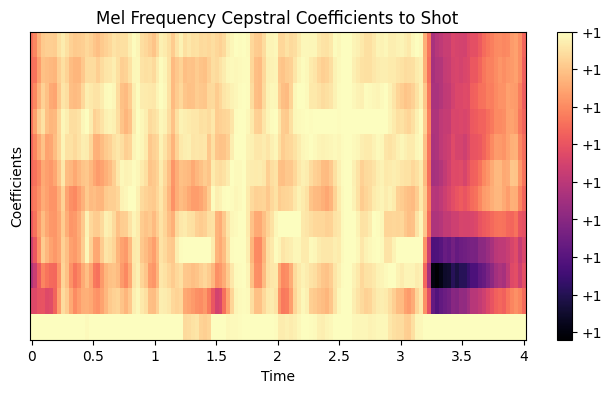

In [ ]:
# SHOT
mfcc = extract_mfccs(shot_sound, SAMPLE_RATE)

plot_mfcc(mfcc, SAMPLE_RATE, 'Shot')

Se normalizo el rango de intensidad entre -1 y 1 para el entrenamiento.

In [ ]:
mfcc.shape

(12, 126)

A diferencia del espetrograma y del espectrograma en la escala de mel, el MFCC representa lo mismo, pero con un tamaño reducido, por lo tanto, el tiempo de entrenamiento tambien sera menor, por eso elegí utilizarlo como input.

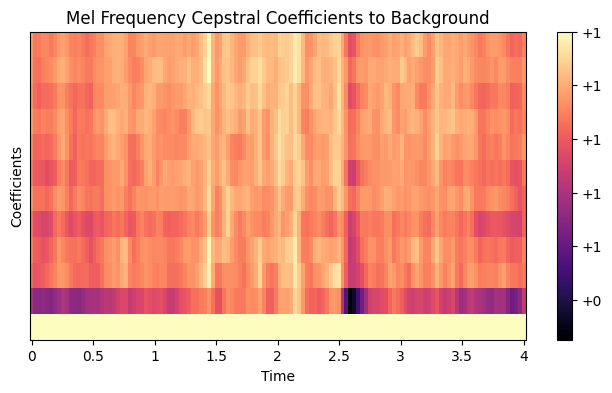

In [ ]:
# BACKGROUND
mfcc = extract_mfccs(back_sound, SAMPLE_RATE)

plot_mfcc(mfcc, SAMPLE_RATE, 'Background')

### Spectral Centroids

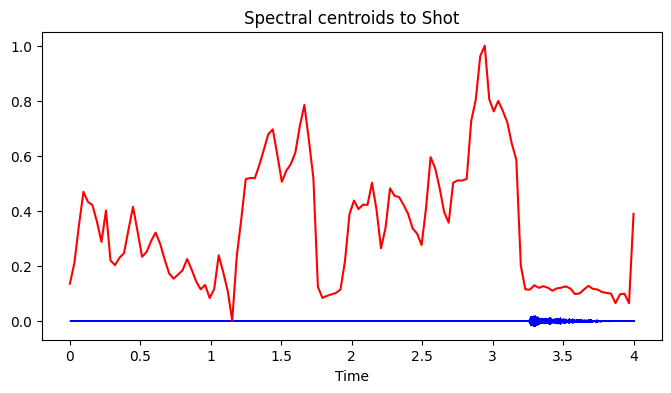

In [ ]:
# SHOT
plot_spectral_centroid(shot_sound, shot_sr, 'Shot')

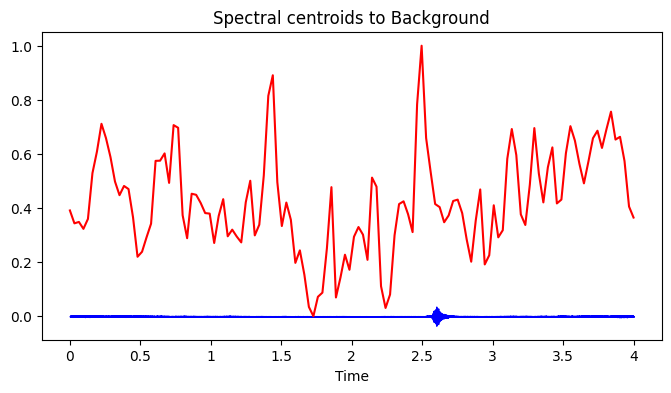

In [ ]:
# BACKGROUND
plot_spectral_centroid(back_sound, back_sr, 'Background')

# Prepare Data to Train and Val

### Train

In [ ]:
shot_dir = DATASET['audio_name'][DATASET['labels'] == 1].values
shot_labels = DATASET['labels'][DATASET['labels'] == 1].values

back_dir = DATASET['audio_name'][DATASET['labels'] == 0].values[:600]
back_label = DATASET['labels'][DATASET['labels'] == 0].values[:600]

shot_signals = [filters(nr.reduce_noise(y=librosa.load(shot_name, sr=SAMPLE_RATE)[0],
                                        sr=SAMPLE_RATE,
                                        n_fft=FRAME_LENGTH,
                                        hop_length=HOP_LENGTH),
                        SAMPLE_RATE) for shot_name in shot_dir]

back_signals = [filters(nr.reduce_noise(y=librosa.load(back_name, sr=SAMPLE_RATE)[0],
                                        sr=SAMPLE_RATE,
                                        n_fft=FRAME_LENGTH,
                                        hop_length=HOP_LENGTH),
                        SAMPLE_RATE) for back_name in back_dir]

### Data Augmentation

In [ ]:
# from audiomentations import Compose, LowPassFilter, Shift, TimeMask

In [ ]:
# Augmentations
# augment = Compose([
#     Shift(min_shift=-1.5, max_shift=1.5, shift_unit='seconds', p=1.0),
#     TimeMask(min_band_part=0.01, max_band_part=0.02, fade=True, p=0.3)
# ])

# # augmented_sounds = [augment(shot, SAMPLE_RATE) for shot in shot_signals]
# augmented_sounds = [filters(nr.reduce_noise(y=augment(shot, SAMPLE_RATE),
#                                             sr=SAMPLE_RATE,
#                                             n_fft=FRAME_LENGTH,
#                                             hop_length=HOP_LENGTH),
#                             SAMPLE_RATE) for shot in shot_signals]

In [ ]:
# shot_signals = np.concatenate((shot_signals, augmented_sounds))
# shot_labels = np.ones(shot_signals.shape[0])

Hay al unos 10k de audios de fondo contra casi 600 de disparos, por lo tanto, equipare la cantidad para tener igual muestras de cada uno, tambien se puede hacer con todos, incluyendo aumento de datos, pero el tiempo a entrenar es mayor y los resultados no fueron muy diferentes.

In [ ]:
# Only for CNN or LSTM
shot_mfcc = np.array([extract_mfccs(shot, SAMPLE_RATE).T for shot in shot_signals])

back_mfcc = np.array([extract_mfccs(back, SAMPLE_RATE).T for back in back_signals])

In [ ]:
X = np.concatenate((shot_mfcc, back_mfcc))
y = np.concatenate((shot_labels, back_label))

In [ ]:
# create train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
X_train = np.concatenate((X_train, X_test)) # CORREGIR
y_train = np.concatenate((y_train, y_test))

X_train = X_train[..., np.newaxis] # ONLY CNN

### Val

In [ ]:
shot_dir = VAL_DATASET['audio_name'][VAL_DATASET['labels'] == 1].values
shot_label = VAL_DATASET['labels'][VAL_DATASET['labels'] == 1].values

back_dir = VAL_DATASET['audio_name'][VAL_DATASET['labels'] == 0].values[:300]
back_label = VAL_DATASET['labels'][VAL_DATASET['labels'] == 0].values[:300]

shot_signals = [filters(nr.reduce_noise(y=librosa.load(shot_name, sr=SAMPLE_RATE)[0],
                                        sr=SAMPLE_RATE,
                                        n_fft=FRAME_LENGTH,
                                        hop_length=HOP_LENGTH),
                        SAMPLE_RATE) for shot_name in shot_dir]

back_signals = [filters(nr.reduce_noise(y=librosa.load(back_name, sr=SAMPLE_RATE)[0],
                                        sr=SAMPLE_RATE,
                                        n_fft=FRAME_LENGTH,
                                        hop_length=HOP_LENGTH),
                        SAMPLE_RATE) for back_name in back_dir]

In [ ]:
# Only for CNN or LSTM
shot_mfcc = np.array([extract_mfccs(shot, SAMPLE_RATE).T for shot in shot_signals])
back_mfcc = np.array([extract_mfccs(back, SAMPLE_RATE).T for back in back_signals])

In [ ]:
X = np.concatenate((shot_mfcc, back_mfcc))
y = np.concatenate((shot_label, back_label))

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

### Info

In [ ]:
print(f"Train shape: {X_train.shape}")

Train shape: (1197, 126, 12, 1)


In [ ]:
print(f"1. Validation shape: {X_val.shape}")

1. Validation shape: (360, 126, 12, 1)


In [ ]:
print(f"Test shape: {X_test.shape}")

Test shape: (90, 126, 12, 1)


In [ ]:
y_test.shape

(90,)

# Implementing a Neural Network

## Plot History

In [ ]:
def plot_history(history):
    """
        Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(3)

    # create accuracy sublpot
    axs[0].plot(history.history["binary_accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_binary_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    # create error sublpot
    axs[2].plot(history.history["auc"], label="train AUC")
    axs[2].plot(history.history["val_auc"], label="test AUC")
    axs[2].set_ylabel("AUC")
    axs[2].set_xlabel("Epoch")
    axs[2].legend(loc="upper right")
    axs[2].set_title("AUC eval")

    plt.show()

## Only dense

In [ ]:
model = keras.Sequential([
        # input layer
        keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),

        # 1st hidden layer
        keras.layers.Dense(512, activation="relu"),

        # 2nd hidden layer
        keras.layers.Dense(256, activation="relu"),

        # 3rd hidden layer
        keras.layers.Dense(64, activation="relu"),

        # output layer
        keras.layers.Dense(1, activation="sigmoid")
        ])

## Convolutional Network

In [ ]:
def build_model(input_shape, nn_parameters):

  """Generates CNN model

  :param input_shape (tuple): Shape of input set
  :param nn_parameters (list): Parameters of the CNN model
  :return model: CNN model
  """

  # create model
  model = keras.Sequential()

  # 1st conv layer
  model.add(keras.layers.Conv2D(nn_parameters[0],
                                (3, 3),
                                activation='relu',
                                input_shape=input_shape))

  model.add(keras.layers.MaxPooling2D((3, 3),
                                      strides=(2, 2),
                                      padding='same'))

  # model.add(keras.layers.BatchNormalization())

  # 2nd conv layer
  model.add(keras.layers.Conv2D(nn_parameters[1],
                                (3, 3),
                                activation='relu'))

  model.add(keras.layers.MaxPooling2D((3, 3),
                                      strides=(2, 2),
                                      padding='same'))

  # model.add(keras.layers.BatchNormalization())

  # 3rd conv layer
  model.add(keras.layers.Conv2D(nn_parameters[2],
                                (2, 2),
                                activation='relu'))

  model.add(keras.layers.MaxPooling2D((2, 2),
                                      strides=(2, 2),
                                      padding='same'))

  # model.add(keras.layers.BatchNormalization())

  # flatten output and feed it into dense layer
  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(nn_parameters[3],
                               activation='relu',
                               kernel_regularizer=keras.regularizers.l2(0.01)))

  # model.add(keras.layers.Dense(nn_parameters[3],
  #                              activation='relu'))

  model.add(keras.layers.Dropout(0.3))

  # output layer
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  return model


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
parameters = [128, 64, 32, 16]

In [ ]:
model = build_model(input_shape, parameters)

## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

def build_model(input_shape):
  model = Sequential()

  # Capas convolucionales
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))

  # Capas recurrentes (LSTM)
  model.add(LSTM(units=128, return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(units=64, activation='relu'))

  # Capa densa para la salida
  model.add(Dense(units=1, activation='sigmoid'))

  return model

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

## Compile network

In [ ]:
def compile_nn(model, verbose=False):
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)

  model.compile(optimizer=optimizer,
                loss=keras.losses.BinaryCrossentropy(),
                metrics=[keras.metrics.BinaryAccuracy(),
                         keras.metrics.AUC(name="auc")])

  if verbose:
    print(model.summary())

In [ ]:
compile_nn(model, True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 124, 32)           1184      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 62, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 60, 16)            1552      
                                                                 
 lstm_2 (LSTM)               (None, 60, 128)           74240     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                      

## Train Network

In [ ]:
checkpoint_filepath = '/content/checkpoint'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath,
                                                monitor="val_auc",
                                                mode="max",
                                                save_best_only=True,
                                                verbose=1)

def train_nn(model):
  # train model
  early_stop = keras.callbacks.EarlyStopping(monitor='val_auc',
                                             patience=10,
                                             restore_best_weights = False)

  history = model.fit(X_train,
                      y_train,
                      validation_data=(X_val, y_val),
                      validation_split=0.2,
                      batch_size=32,
                      epochs=100,
                      callbacks=[early_stop, checkpoint])

  return history

In [ ]:
history = train_nn(model)

Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 0.6925 - binary_accuracy: 0.4979 - auc: 0.5409
Epoch 1: val_auc improved from -inf to 0.72004, saving model to /content/checkpoint
38/38 [==============================] - 17s 350ms/step - loss: 0.6925 - binary_accuracy: 0.4979 - auc: 0.5409 - val_loss: 0.7016 - val_binary_accuracy: 0.3278 - val_auc: 0.7200
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 0.6920 - binary_accuracy: 0.5263 - auc: 0.5418
Epoch 2: val_auc improved from 0.72004 to 0.74932, saving model to /content/checkpoint
38/38 [==============================] - 12s 312ms/step - loss: 0.6920 - binary_accuracy: 0.5263 - auc: 0.5418 - val_loss: 0.6945 - val_binary_accuracy: 0.3611 - val_auc: 0.7493
Epoch 3/100
38/38 [==============================] - ETA: 0s - loss: 0.6918 - binary_accuracy: 0.5146 - auc: 0.5568
Epoch 3: val_auc improved from 0.74932 to 0.80079, saving model to /content/checkpoint
38/38 [==============================]

## Load model

In [ ]:
model = keras.models.load_model("/content/CNN_MODEL.keras")

## Evaluate model

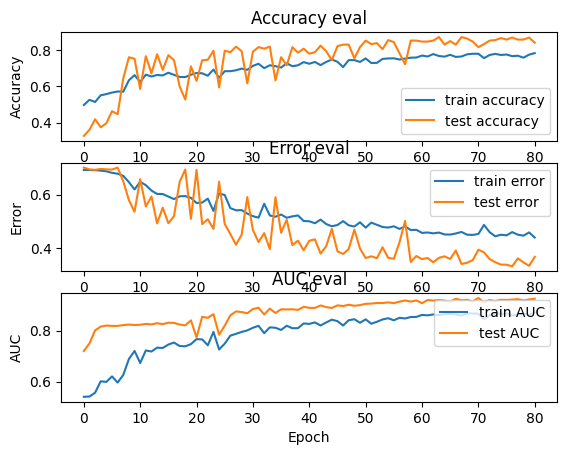

In [ ]:
plot_history(history)

In [ ]:
# load best weights
model.load_weights(checkpoint_filepath)

In [ ]:
# evaluate model on test set
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=2)

3/3 - 0s - loss: 0.5203 - binary_accuracy: 0.8444 - auc: 0.9419 - 462ms/epoch - 154ms/step


In [ ]:
shoot_index = [i for i, e in enumerate(y_test) if e == 1]

X_shoot = X_test[shoot_index]
y_shoot = y_test[shoot_index]

In [ ]:
# evaluate model on test set only shoots
val_loss, val_acc, val_auc = model.evaluate(X_shoot, y_shoot, verbose=2)

2/2 - 0s - loss: 0.5042 - binary_accuracy: 0.8333 - auc: 0.0000e+00 - 110ms/epoch - 55ms/step


In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[2]
X_to_predict = X_to_predict[np.newaxis, ...]
y_to_predict = y_test[2]

prediction = round(model.predict(X_to_predict)[0][0])

print("Target: {}, Predicted label: {}".format(y_to_predict, prediction))

1/1 [==============================] - 0s 127ms/step
Target: 0, Predicted label: 0


In [ ]:
# Confusion matrix

prediction = model.predict(X_test)
prediction = np.array([round(pred[0]) for pred in prediction])

tf.math.confusion_matrix(labels=y_test, predictions=prediction, num_classes=2)

3/3 [==============================] - 0s 33ms/step


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[46,  8],
       [ 6, 30]], dtype=int32)>

En este caso se redondea a 1 a partir de 0.5 para arriba, pero en los audios de "lotes_procesar" hay casos que con 0.7 que indicaría un disparo, no lo hay, por lo tanto, se definira un umbral como indice de probabilidad.

Esta parte tiene mejores resultados ya que habia cargado los mejores pesos, en la parte de abajo donde se carga el modelo fue el ultimo resultado de la ultima epoca de entrenamiento.

## Save model

In [ ]:
model.save("LSTM_MODEL.keras")

# Genetic Algorithms

In [ ]:
!pip install pygad

In [ ]:
import pygad
import pygad.kerasga
from pygad import GA

In [ ]:
def fitness_func(ga_instance, solution, sol_idx):
  global data_inputs, data_outputs, keras_ga, model

  predictions = pygad.kerasga.predict(model=model,
                                      solution=solution,
                                      data=data_inputs).T[0]

  bce = keras.losses.BinaryCrossentropy()

  solution_fitness = 1.0 / (bce(data_outputs, predictions).numpy() + 0.00000001)

  return solution_fitness

In [ ]:
def on_generation(ga_instance):
  print(f"Generation = {ga_instance.generations_completed}")
  print(f"Fitness    = {ga_instance.best_solution()[1]}")

In [ ]:
# Create an instance of the pygad.kerasga.KerasGA class to build the initial population.
keras_ga = pygad.kerasga.KerasGA(model=model,
                                 num_solutions=10)

In [ ]:
data_inputs = X_test
data_outputs = y_test

In [ ]:
# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/pygad.html#pygad-ga-class
num_generations = 50 # Number of generations.
num_parents_mating = 4 # Number of solutions to be selected as parents in the mating pool.
initial_population = keras_ga.population_weights # Initial population of network weights.

In [ ]:
# Create an instance of the pygad.GA class
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       parent_selection_type="tournament",
                       K_tournament=1,
                       keep_elitism=1,
                       crossover_type="single_point",
                       crossover_probability=0.75,
                       mutation_type="swap",
                       mutation_probability=0.4,
                       on_generation=on_generation,
                       allow_duplicate_genes=False)

/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


In [ ]:
# Start the genetic algorithm evolution.
ga_instance.run()

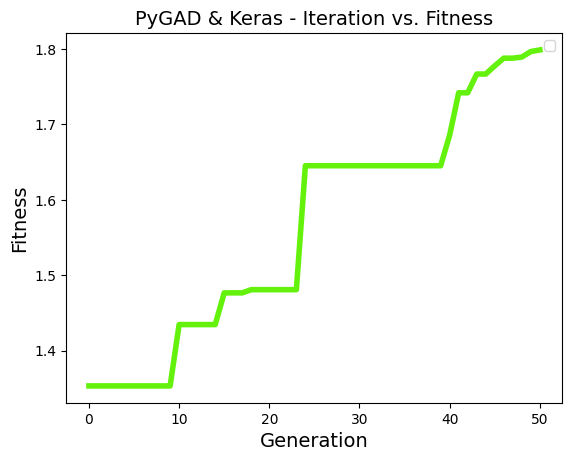

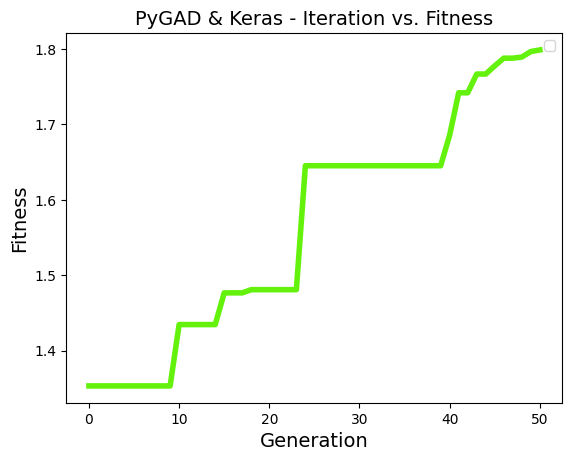

In [ ]:
ga_instance.plot_fitness(title="PyGAD & Keras - Iteration vs. Fitness", linewidth=4)

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

Fitness value of the best solution = 1.7987543540423576
Index of the best solution : 2


In [ ]:
predictions = pygad.kerasga.predict(model=model,
                                    solution=solution,
                                    data=data_inputs).T[0]
print("Predictions : \n", predictions)

Predictions : 
 [0.5362474  0.21788484 0.49211833 0.45830947 0.6269754  0.47782385
 0.4104768  0.55424964 0.45856306 0.2942096  0.4262539  0.39205253
 0.5276558  0.45568654 0.5362145  0.2688334  0.27193868 0.28255787
 0.4386079  0.58630306 0.48192602 0.32404602 0.48175433 0.6329158
 0.6520494  0.40612394 0.20904298 0.2897988  0.4324713  0.4935825
 0.32292432 0.44134772 0.46460456 0.6332055  0.42663762 0.25514558
 0.3838635  0.2998979  0.51590294 0.25993666 0.40218753 0.4255529
 0.4592288  0.4963978  0.47331274 0.3809227  0.6612983  0.23149276
 0.58656913 0.46390975 0.27908242 0.23589535 0.5749378  0.22333193
 0.5287079  0.28301325 0.3480323  0.5946977  0.42152235 0.466905
 0.38149685 0.21315682 0.5976974  0.459182   0.5331035  0.56911635
 0.6301532  0.61754507 0.19798808 0.37487662 0.5989079  0.27476597
 0.23764212 0.6300469  0.265304   0.3425759  0.21582134 0.35463548
 0.43304062 0.40810266 0.443464   0.45353884 0.614485   0.4862024
 0.6157456  0.51174486 0.33110937 0.6195941  0.49931

In [ ]:
bce = keras.losses.BinaryCrossentropy()
result = 1.0 / (bce(data_outputs, predictions).numpy() + 0.00000001)
print(result)

1.7987543540423576


In [ ]:
ba = keras.metrics.BinaryAccuracy()
ba.update_state(data_outputs, predictions)
accuracy = ba.result().numpy()
print("Accuracy : ", accuracy)

Accuracy :  0.73333335


In [ ]:
# Confusion matrix
predictions = [round(pred) for pred in predictions]

tf.math.confusion_matrix(labels=y_test, predictions=predictions, num_classes=2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[49,  9],
       [15, 17]], dtype=int32)>

# Load complete sound to infer

In [ ]:
!cp /content/lotes_procesar/BO-01_OBBA-4_20191009_174300.mp3 /content/TRUE

In [ ]:
THRESHOLD= 0.8
SEGMENT_DURATION = 4 # measured in second

FOLDER_PATH = '/content/lotes_procesar'
AUDIOS = os.listdir(FOLDER_PATH)

TRUE_AUDIOS = {}

In [ ]:
len(AUDIOS)

165

In [ ]:
def extract_segments(signal, samples_per_segment, num_segments):

  segments = []

  for s in range(num_segments):
    start = s * samples_per_segment
    finish = start + samples_per_segment

    segment = signal[start:finish]

    segments.append(segment)

  return np.array(segments)

In [ ]:
for audio in AUDIOS:

  signal, _ = librosa.load(os.path.join(FOLDER_PATH, audio), sr = SAMPLE_RATE)
  signal = nr.reduce_noise(y=signal, sr=SAMPLE_RATE,
                           n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
  signal = filters(signal, SAMPLE_RATE)

  # extract audio duration
  duration = len(signal)//SAMPLE_RATE

  # get number of SEGMENT_DURATION second segments
  num_segments = duration//SEGMENT_DURATION

  # get samples per segments
  samples_per_segments = SEGMENT_DURATION * SAMPLE_RATE

  # extract 'num_segments' segments of 'SEGMENT_DURATION' seconds
  segments = extract_segments(signal, samples_per_segments, num_segments)

  # extract mfcc for each segment
  mfcc = np.array([extract_mfccs(seg, SAMPLE_RATE).T for seg in segments])

  mfcc = mfcc[..., np.newaxis]

  # predictions = pygad.kerasga.predict(model=model,
  #                                   solution=solution,
  #                                   data=data_inputs).T[0]

  predictions = model.predict(mfcc, verbose=0).T[0]

  if len(predictions[predictions >= THRESHOLD]) > 0:
    print("True Audio: {}".format(audio))
    TRUE_AUDIOS[audio] = predictions

True Audio: BO-06_OBBA-10_20191012_221500 .mp3
True Audio: BO-06_OBBA-10_20191010_231400 .mp3
True Audio: BO-03_OBBA-7_20191010_001300 .mp3
True Audio: BO-07_OBBA-20_20191024_002100 .mp3
True Audio: BO-07_OBBA-20_20191022_061700 .mp3
True Audio: BO-07_OBBA-20_20191023_232100 .mp3
True Audio: BO-06_OBBA-10_20191011_070800 .mp3
True Audio: BO-06_OBBA-10_20191014_054500 .mp3
True Audio: BO-07_OBBA-20_20191019_070000 .mp3
True Audio: BO-06_OBBA-10_20191013_211500 .mp3
True Audio: BO-06_OBBA-10_20191011_174400 .mp3
True Audio: BO-06_OBBA-10_20191014_182600 .mp3
True Audio: BO-01_OBBA-4_20191009_182300.mp3
True Audio: BO-03_OBBA-7_20191009_221300 .mp3
True Audio: BO-06_OBBA-10_20191011_211400 .mp3
True Audio: BO-01_OBBA-4_20191010_062900 .mp3
True Audio: BO-04_OBBA-12_20191009_231300 .mp3
True Audio: BO-01_OBBA-4_20191009_211300.mp3
True Audio: BO-07_OBBA-20_20191024_045500 .mp3
True Audio: BO-07_OBBA-20_20191020_182900 .mp3
True Audio: BO-07_OBBA-20_20191021_232000 .mp3
True Audio: BO-06_OB

In [ ]:
def get_time_stamp(name, preds):
  print("AUDIO: {}".format(name))

  for i in range(len(preds)):
    pred = preds[i]

    if pred >= THRESHOLD:
      start_seconds = SEGMENT_DURATION * i
      end_seconds = start_seconds + SEGMENT_DURATION

      # Convert to minutes if exceeding 60 seconds
      if end_seconds > 60:
        start_minutes = start_seconds // 60
        start_seconds = start_seconds % 60
        end_minutes = end_seconds // 60
        end_seconds = end_seconds % 60

        print("Shot between: {}:{} and {}:{} minutes, probability: {}"
                                                        .format(start_minutes,
                                                                start_seconds,
                                                                end_minutes,
                                                                end_seconds,
                                                                round(pred, 3)))
      else:
        print("Shot between: {} and {} seconds, probability: {}"
                                                        .format(start_seconds,
                                                                end_seconds,
                                                                round(pred, 3)))

In [ ]:
len(TRUE_AUDIOS)

91

In [ ]:
total_preds = list(TRUE_AUDIOS.items())

In [ ]:
index = 16
n = total_preds[index][0]
p = total_preds[index][1]

get_time_stamp(n, p)

AUDIO: BO-04_OBBA-12_20191009_231300 .mp3
Shot between: 24 and 28 seconds, probability: 0.8870000243186951
Shot between: 2:32 and 2:36 minutes, probability: 0.8289999961853027
Shot between: 4:12 and 4:16 minutes, probability: 0.8019999861717224
Shot between: 6:0 and 6:4 minutes, probability: 0.8889999985694885
Shot between: 6:20 and 6:24 minutes, probability: 0.8040000200271606


El problema aca es que como parto los audios en segmentos de 4 segundos, puedo por ejemeplo en el segmento 3, hacer un corte justo en la mitad de la representacion espectral del disparo, eso lo tratare de resolver haciendo cortes con un delta de tiempo al principio, es decir, primero de la forma en la que esta, empezando del segundo 0 hasta el 4, luego del 1 hasta el 5, y asi, hasta encontrar una mejor forma, de momento funciona si no se corta el espectro.